# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

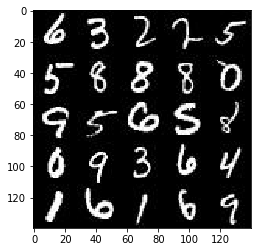

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

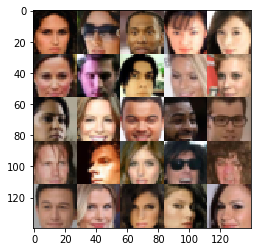

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    inputs_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim), name='inputs_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    alpha = 0.01
    
    with tf.variable_scope('discriminator',  reuse=reuse):
        # 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images,  64, 5, strides=2, padding='same')
        # Do not use BatchNormalization here
        relu1 = tf.maximum(alpha * x1, x1) # Leaky ReLU
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2) # Leaky ReLU
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3) # Leaky ReLU
        # 4x4x256
        
        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.01
    
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z,  4 * 4 * 256, activation=None)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1) # Leaky ReLU
        # 4x4x256
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2) # Leaky ReLU
        # 7x7x128
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3) # Leaky ReLU
        # 14x14x64
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 or 28x28x1
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    smoothed_labels = tf.ones_like(d_logits_real) * (1 - smooth)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=smoothed_labels))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))   
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    # https://discussions.udacity.com/t/list-index-out-of-range-on-last-epoch-for-mnist/247664/4
    #tf.reset_default_graph()

    # data_shape=(60000, 28, 28, 1)
    inputs_real, inputs_z, lr = model_inputs(data_shape[2], data_shape[1], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
        
    steps = 0
    print_every=10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # rescale to (-1,1)
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, lr: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, len(batch_images), inputs_z, data_shape[3], data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.6722... Generator Loss: 4.1227
Epoch 1/2... Discriminator Loss: 0.7197... Generator Loss: 4.7191
Epoch 1/2... Discriminator Loss: 0.7554... Generator Loss: 1.7980
Epoch 1/2... Discriminator Loss: 0.5008... Generator Loss: 2.5514
Epoch 1/2... Discriminator Loss: 0.4578... Generator Loss: 3.2626
Epoch 1/2... Discriminator Loss: 0.3962... Generator Loss: 3.2420
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 2.7746
Epoch 1/2... Discriminator Loss: 0.5825... Generator Loss: 6.3239
Epoch 1/2... Discriminator Loss: 0.3946... Generator Loss: 5.7128
Epoch 1/2... Discriminator Loss: 0.4399... Generator Loss: 3.0474


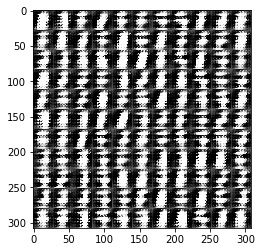

Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 3.3653
Epoch 1/2... Discriminator Loss: 0.7813... Generator Loss: 1.9340
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 2.9814
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.6816
Epoch 1/2... Discriminator Loss: 0.6763... Generator Loss: 2.2483
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.9674
Epoch 1/2... Discriminator Loss: 0.9429... Generator Loss: 2.9883
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.8787
Epoch 1/2... Discriminator Loss: 1.6102... Generator Loss: 0.5512
Epoch 1/2... Discriminator Loss: 1.2179... Generator Loss: 2.8312


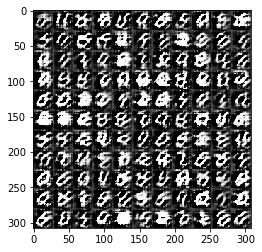

Epoch 1/2... Discriminator Loss: 1.1305... Generator Loss: 0.9281
Epoch 1/2... Discriminator Loss: 1.4511... Generator Loss: 0.5372
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 0.9506
Epoch 1/2... Discriminator Loss: 1.1439... Generator Loss: 1.0119
Epoch 1/2... Discriminator Loss: 1.1224... Generator Loss: 1.0144
Epoch 1/2... Discriminator Loss: 1.0674... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 1.0710... Generator Loss: 1.5707
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.0632... Generator Loss: 0.9810


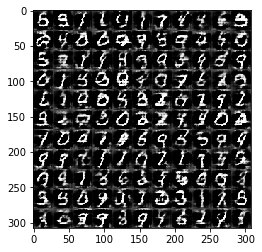

Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 1.8550... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: 1.0939... Generator Loss: 1.0493
Epoch 1/2... Discriminator Loss: 1.1626... Generator Loss: 0.8141
Epoch 1/2... Discriminator Loss: 2.2850... Generator Loss: 3.3638
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 1.6591
Epoch 1/2... Discriminator Loss: 1.0787... Generator Loss: 1.0720
Epoch 1/2... Discriminator Loss: 1.0173... Generator Loss: 1.0077
Epoch 1/2... Discriminator Loss: 1.3163... Generator Loss: 0.7259
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 0.7755


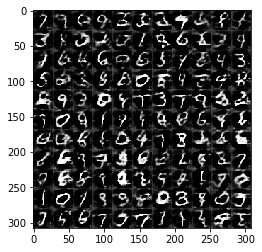

Epoch 1/2... Discriminator Loss: 1.3805... Generator Loss: 2.7522
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.8987
Epoch 1/2... Discriminator Loss: 1.0327... Generator Loss: 1.2398
Epoch 1/2... Discriminator Loss: 1.0293... Generator Loss: 1.2268
Epoch 1/2... Discriminator Loss: 1.0907... Generator Loss: 0.9394
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 1.1313... Generator Loss: 1.3749
Epoch 2/2... Discriminator Loss: 1.2269... Generator Loss: 1.8535
Epoch 2/2... Discriminator Loss: 1.1995... Generator Loss: 0.7154
Epoch 2/2... Discriminator Loss: 1.0099... Generator Loss: 1.0770


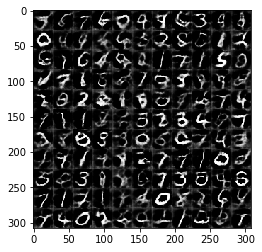

Epoch 2/2... Discriminator Loss: 1.4459... Generator Loss: 0.5214
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.8279
Epoch 2/2... Discriminator Loss: 1.0037... Generator Loss: 1.2008
Epoch 2/2... Discriminator Loss: 1.1798... Generator Loss: 1.5968
Epoch 2/2... Discriminator Loss: 1.1579... Generator Loss: 0.7548
Epoch 2/2... Discriminator Loss: 1.4956... Generator Loss: 0.5076
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 1.8043
Epoch 2/2... Discriminator Loss: 1.6463... Generator Loss: 2.2532
Epoch 2/2... Discriminator Loss: 1.2663... Generator Loss: 0.6537
Epoch 2/2... Discriminator Loss: 1.5622... Generator Loss: 0.4323


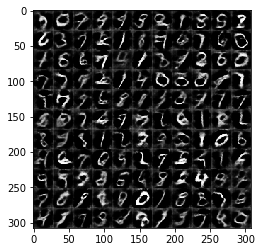

Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 2.4869
Epoch 2/2... Discriminator Loss: 1.7528... Generator Loss: 0.3596
Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 0.6764
Epoch 2/2... Discriminator Loss: 1.2862... Generator Loss: 0.6372
Epoch 2/2... Discriminator Loss: 1.1424... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 1.6352... Generator Loss: 3.0299
Epoch 2/2... Discriminator Loss: 1.0507... Generator Loss: 1.0358
Epoch 2/2... Discriminator Loss: 1.2085... Generator Loss: 1.4141
Epoch 2/2... Discriminator Loss: 1.0005... Generator Loss: 1.6699
Epoch 2/2... Discriminator Loss: 1.2821... Generator Loss: 0.7114


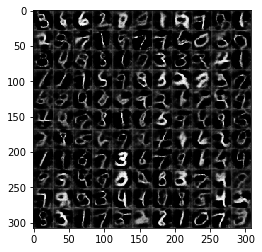

Epoch 2/2... Discriminator Loss: 1.1238... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 2.4818... Generator Loss: 0.1840
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.9932
Epoch 2/2... Discriminator Loss: 1.5324... Generator Loss: 2.3069
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 1.3528
Epoch 2/2... Discriminator Loss: 1.0340... Generator Loss: 1.0837
Epoch 2/2... Discriminator Loss: 1.1735... Generator Loss: 1.6789
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 1.2055
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 1.3426... Generator Loss: 0.5850


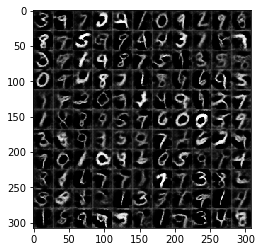

Epoch 2/2... Discriminator Loss: 1.7747... Generator Loss: 0.3432
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 0.8280
Epoch 2/2... Discriminator Loss: 1.1285... Generator Loss: 0.7820
Epoch 2/2... Discriminator Loss: 1.6436... Generator Loss: 2.4207
Epoch 2/2... Discriminator Loss: 1.5321... Generator Loss: 0.4634
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 1.5562
Epoch 2/2... Discriminator Loss: 1.3484... Generator Loss: 0.5650
Epoch 2/2... Discriminator Loss: 1.5752... Generator Loss: 2.2903
Epoch 2/2... Discriminator Loss: 1.2020... Generator Loss: 0.7802
Epoch 2/2... Discriminator Loss: 1.4523... Generator Loss: 0.5102


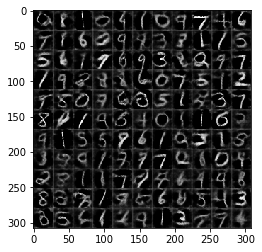

Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 1.7293
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.5973
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 1.4526


In [23]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0420... Generator Loss: 6.5755
Epoch 1/1... Discriminator Loss: 7.9451... Generator Loss: 0.0007
Epoch 1/1... Discriminator Loss: 0.5691... Generator Loss: 8.3030
Epoch 1/1... Discriminator Loss: 2.0911... Generator Loss: 0.4850
Epoch 1/1... Discriminator Loss: 0.8812... Generator Loss: 1.4827
Epoch 1/1... Discriminator Loss: 0.6878... Generator Loss: 2.9003
Epoch 1/1... Discriminator Loss: 0.6177... Generator Loss: 1.5926
Epoch 1/1... Discriminator Loss: 0.4975... Generator Loss: 2.9031
Epoch 1/1... Discriminator Loss: 0.7290... Generator Loss: 1.9354
Epoch 1/1... Discriminator Loss: 0.6356... Generator Loss: 1.9771


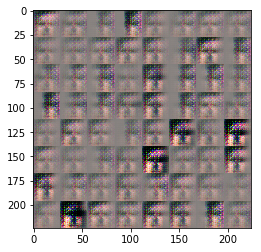

Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 1.6812
Epoch 1/1... Discriminator Loss: 1.0638... Generator Loss: 1.2245
Epoch 1/1... Discriminator Loss: 0.9504... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.9546... Generator Loss: 1.9102
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 1.7026
Epoch 1/1... Discriminator Loss: 2.0032... Generator Loss: 4.4716
Epoch 1/1... Discriminator Loss: 2.2528... Generator Loss: 5.4092
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8225


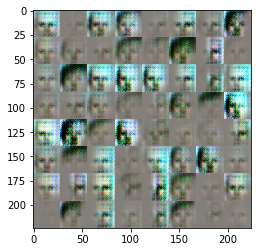

Epoch 1/1... Discriminator Loss: 2.1514... Generator Loss: 0.2300
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.5186
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 1.4229
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 2.9918
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 1.8738
Epoch 1/1... Discriminator Loss: 1.8593... Generator Loss: 3.5244
Epoch 1/1... Discriminator Loss: 0.9899... Generator Loss: 1.0110


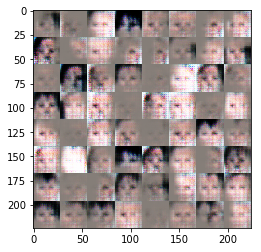

Epoch 1/1... Discriminator Loss: 1.0459... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 0.6326... Generator Loss: 2.2027
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 2.5966
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 1.8770
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.1343
Epoch 1/1... Discriminator Loss: 2.0800... Generator Loss: 3.8369
Epoch 1/1... Discriminator Loss: 0.7631... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 1.6776... Generator Loss: 0.4219
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 1.4920


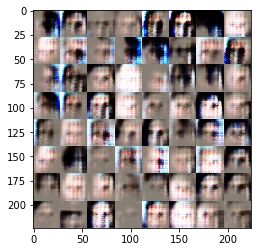

Epoch 1/1... Discriminator Loss: 1.6242... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.5809... Generator Loss: 3.8912
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 0.8776... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.6158... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 0.8974... Generator Loss: 1.2520
Epoch 1/1... Discriminator Loss: 0.8990... Generator Loss: 3.1935
Epoch 1/1... Discriminator Loss: 0.9765... Generator Loss: 1.3069
Epoch 1/1... Discriminator Loss: 1.4301... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.2146


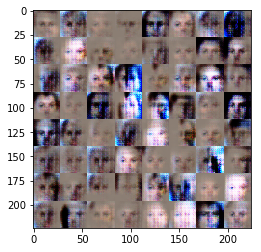

Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 0.8490... Generator Loss: 1.1785
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 0.7188... Generator Loss: 1.6082
Epoch 1/1... Discriminator Loss: 1.9225... Generator Loss: 3.2561
Epoch 1/1... Discriminator Loss: 0.8198... Generator Loss: 1.5773
Epoch 1/1... Discriminator Loss: 0.6535... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.0388
Epoch 1/1... Discriminator Loss: 1.5289... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.0050


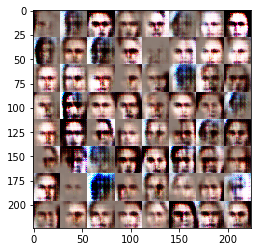

Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 1.2144
Epoch 1/1... Discriminator Loss: 0.9525... Generator Loss: 1.4713
Epoch 1/1... Discriminator Loss: 0.8232... Generator Loss: 1.1322
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5370
Epoch 1/1... Discriminator Loss: 0.6881... Generator Loss: 1.9850
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.2159
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 1.6611
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.8992
Epoch 1/1... Discriminator Loss: 0.8486... Generator Loss: 1.7052
Epoch 1/1... Discriminator Loss: 3.1896... Generator Loss: 7.0958


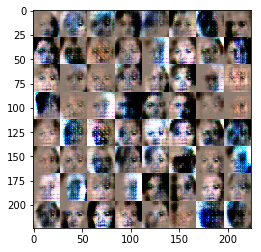

Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.5181
Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.5713
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6092
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.7092
Epoch 1/1... Discriminator Loss: 0.9037... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.0853... Generator Loss: 1.1193
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 2.3545
Epoch 1/1... Discriminator Loss: 0.6846... Generator Loss: 1.4412
Epoch 1/1... Discriminator Loss: 0.9725... Generator Loss: 1.3394


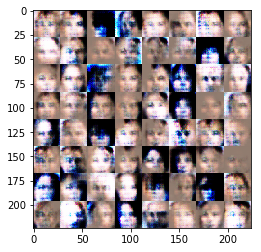

Epoch 1/1... Discriminator Loss: 0.8557... Generator Loss: 1.4201
Epoch 1/1... Discriminator Loss: 0.7647... Generator Loss: 1.4275
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 0.8207... Generator Loss: 1.2320
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 2.0862
Epoch 1/1... Discriminator Loss: 0.7730... Generator Loss: 1.4615
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.6861
Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 1.0476... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 2.1786


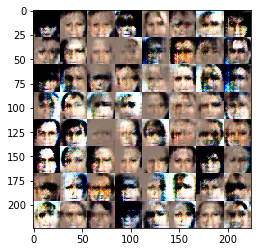

Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 2.7278
Epoch 1/1... Discriminator Loss: 1.8613... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 0.8602... Generator Loss: 1.4683
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 1.5437
Epoch 1/1... Discriminator Loss: 1.0336... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 0.5182... Generator Loss: 2.4544
Epoch 1/1... Discriminator Loss: 0.9973... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 1.5268
Epoch 1/1... Discriminator Loss: 0.8210... Generator Loss: 2.0892


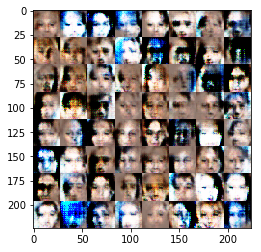

Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.8856
Epoch 1/1... Discriminator Loss: 1.7600... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 2.1068
Epoch 1/1... Discriminator Loss: 0.8155... Generator Loss: 1.1876
Epoch 1/1... Discriminator Loss: 0.7052... Generator Loss: 1.3251
Epoch 1/1... Discriminator Loss: 0.8981... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.7686... Generator Loss: 1.2824
Epoch 1/1... Discriminator Loss: 0.8891... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.0689... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 1.0695


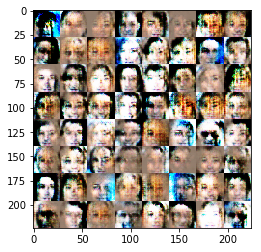

Epoch 1/1... Discriminator Loss: 0.7275... Generator Loss: 1.4154
Epoch 1/1... Discriminator Loss: 0.6635... Generator Loss: 1.8113
Epoch 1/1... Discriminator Loss: 1.2768... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 0.7913... Generator Loss: 1.3843
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 1.7332
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.8882
Epoch 1/1... Discriminator Loss: 1.3607... Generator Loss: 1.1992
Epoch 1/1... Discriminator Loss: 0.9003... Generator Loss: 1.1263
Epoch 1/1... Discriminator Loss: 0.9658... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 0.9049... Generator Loss: 1.0899


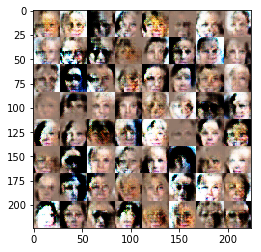

Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 2.3000
Epoch 1/1... Discriminator Loss: 0.9002... Generator Loss: 2.3599
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 0.8737
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.9349
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.9356
Epoch 1/1... Discriminator Loss: 0.8237... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 0.8922... Generator Loss: 1.1728
Epoch 1/1... Discriminator Loss: 1.4840... Generator Loss: 0.4921
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.2976
Epoch 1/1... Discriminator Loss: 0.6160... Generator Loss: 1.8420


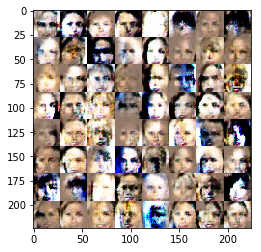

Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.1755
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 0.7816
Epoch 1/1... Discriminator Loss: 0.8800... Generator Loss: 1.3093
Epoch 1/1... Discriminator Loss: 0.8213... Generator Loss: 1.1486
Epoch 1/1... Discriminator Loss: 1.0088... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 1.1259
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 1.1826
Epoch 1/1... Discriminator Loss: 0.7102... Generator Loss: 2.0449
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 2.4174


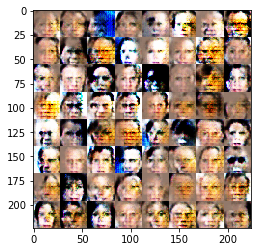

Epoch 1/1... Discriminator Loss: 1.0214... Generator Loss: 1.1526
Epoch 1/1... Discriminator Loss: 1.1364... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 1.9364
Epoch 1/1... Discriminator Loss: 0.7429... Generator Loss: 1.6019
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 2.0102
Epoch 1/1... Discriminator Loss: 0.7928... Generator Loss: 1.6833
Epoch 1/1... Discriminator Loss: 1.6295... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 0.6951... Generator Loss: 1.4328
Epoch 1/1... Discriminator Loss: 1.1020... Generator Loss: 1.2626


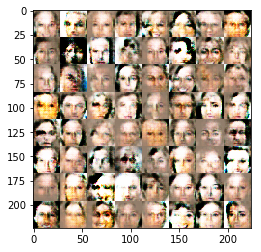

Epoch 1/1... Discriminator Loss: 0.8719... Generator Loss: 1.8979
Epoch 1/1... Discriminator Loss: 1.0567... Generator Loss: 1.8999
Epoch 1/1... Discriminator Loss: 1.1440... Generator Loss: 1.0356
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 1.7968
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 2.4172
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 0.8835
Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 1.6866
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.3339
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.9603
Epoch 1/1... Discriminator Loss: 0.9702... Generator Loss: 1.7715


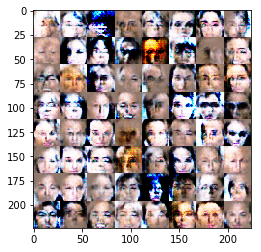

Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.7421
Epoch 1/1... Discriminator Loss: 0.9282... Generator Loss: 1.3551
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.4730
Epoch 1/1... Discriminator Loss: 0.7889... Generator Loss: 1.2094
Epoch 1/1... Discriminator Loss: 0.8138... Generator Loss: 1.4939
Epoch 1/1... Discriminator Loss: 0.9213... Generator Loss: 1.2237
Epoch 1/1... Discriminator Loss: 1.0152... Generator Loss: 2.4996
Epoch 1/1... Discriminator Loss: 0.8618... Generator Loss: 1.7176
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 1.2221
Epoch 1/1... Discriminator Loss: 0.7824... Generator Loss: 1.5205


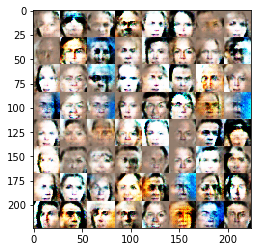

Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 1.2678
Epoch 1/1... Discriminator Loss: 1.0019... Generator Loss: 1.7210
Epoch 1/1... Discriminator Loss: 0.7857... Generator Loss: 1.7348
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 2.2664
Epoch 1/1... Discriminator Loss: 0.8193... Generator Loss: 1.2027
Epoch 1/1... Discriminator Loss: 0.8269... Generator Loss: 1.8224
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 2.1935
Epoch 1/1... Discriminator Loss: 0.9153... Generator Loss: 1.5303


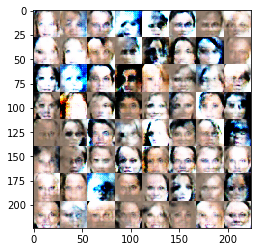

Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 2.0050
Epoch 1/1... Discriminator Loss: 1.0223... Generator Loss: 0.9619
Epoch 1/1... Discriminator Loss: 0.9990... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 0.8417... Generator Loss: 1.2793
Epoch 1/1... Discriminator Loss: 1.1921... Generator Loss: 1.0722
Epoch 1/1... Discriminator Loss: 0.9429... Generator Loss: 1.3933
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.8857
Epoch 1/1... Discriminator Loss: 0.7431... Generator Loss: 1.3260
Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 1.2238


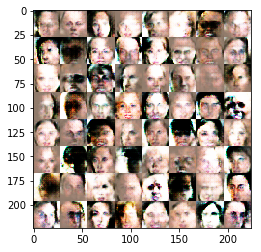

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 2.1086
Epoch 1/1... Discriminator Loss: 0.7581... Generator Loss: 1.2919
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 0.9092... Generator Loss: 1.3060
Epoch 1/1... Discriminator Loss: 0.8964... Generator Loss: 1.0614
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 1.6552
Epoch 1/1... Discriminator Loss: 1.0128... Generator Loss: 1.1652
Epoch 1/1... Discriminator Loss: 1.1571... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 0.9811... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 1.0800


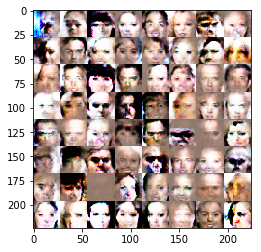

Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.0841... Generator Loss: 1.7178
Epoch 1/1... Discriminator Loss: 0.8743... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 2.3248
Epoch 1/1... Discriminator Loss: 0.9614... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.2001... Generator Loss: 2.5888
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.8612
Epoch 1/1... Discriminator Loss: 0.8920... Generator Loss: 1.5189
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.3818


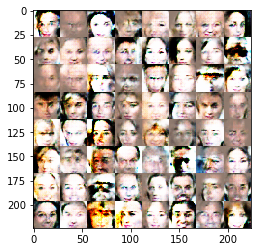

Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 0.9807... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 1.2514... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.0817... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 0.9054... Generator Loss: 1.3081
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 0.9816... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 1.5135


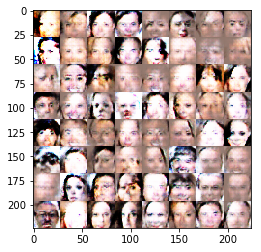

Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.8636... Generator Loss: 1.2584
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.6160
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.3276
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.5656
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 1.5064
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.0013... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.4430


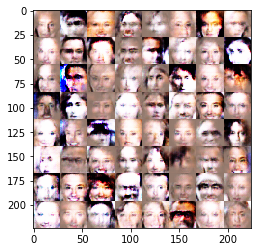

Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 1.0297
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 1.5318
Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 1.1792
Epoch 1/1... Discriminator Loss: 0.9480... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 1.0136... Generator Loss: 0.9613
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 1.2201... Generator Loss: 0.6702


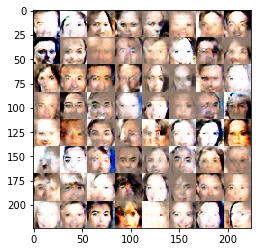

Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.0268... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.0792... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 0.9405... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 1.0480
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 1.9590
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 2.3176
Epoch 1/1... Discriminator Loss: 1.0347... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 0.9750... Generator Loss: 1.7274


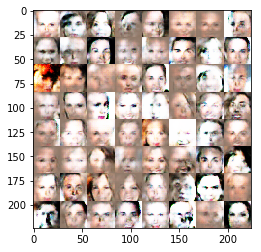

Epoch 1/1... Discriminator Loss: 1.0964... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.1261... Generator Loss: 1.2443
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.9869
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 1.3388
Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.5999
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.0049... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 0.9731... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9155


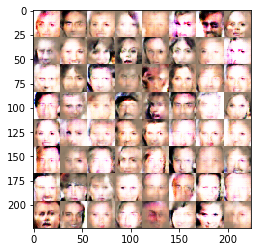

Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 1.0177
Epoch 1/1... Discriminator Loss: 0.9300... Generator Loss: 1.1848
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 0.9059... Generator Loss: 1.4949
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 1.0831
Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 2.0679
Epoch 1/1... Discriminator Loss: 0.9108... Generator Loss: 1.4120


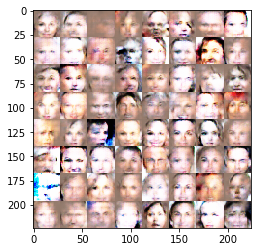

Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.9725
Epoch 1/1... Discriminator Loss: 1.6996... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.9402
Epoch 1/1... Discriminator Loss: 0.9445... Generator Loss: 1.0366
Epoch 1/1... Discriminator Loss: 0.8460... Generator Loss: 1.5489
Epoch 1/1... Discriminator Loss: 1.2973... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6540
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 1.0165
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.5916
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 1.3985


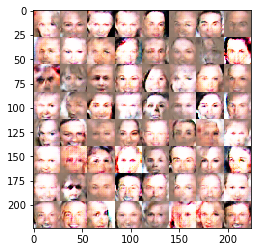

Epoch 1/1... Discriminator Loss: 0.9766... Generator Loss: 1.0058
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.1678
Epoch 1/1... Discriminator Loss: 1.0033... Generator Loss: 1.5826
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 2.9406
Epoch 1/1... Discriminator Loss: 0.9521... Generator Loss: 1.5115
Epoch 1/1... Discriminator Loss: 1.0847... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.9706
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.0854
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 0.9591
Epoch 1/1... Discriminator Loss: 1.0605... Generator Loss: 0.8006


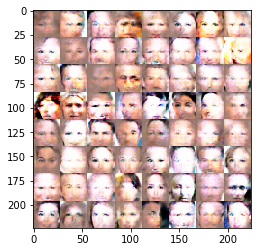

Epoch 1/1... Discriminator Loss: 1.0021... Generator Loss: 1.6554
Epoch 1/1... Discriminator Loss: 0.9849... Generator Loss: 1.9515
Epoch 1/1... Discriminator Loss: 1.0319... Generator Loss: 1.0182
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.8079... Generator Loss: 0.3747
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.8513
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.8045
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.9090
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 2.2589
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 0.8518


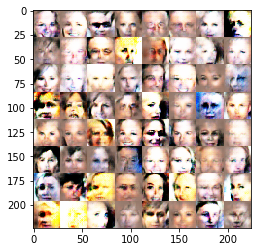

Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.4947
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.5066
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 0.8681... Generator Loss: 1.2195
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.5488
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.0061... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.0210... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.9115... Generator Loss: 1.1902


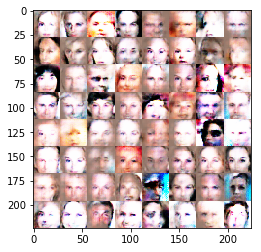

Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 3.0041
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.0937... Generator Loss: 1.9862
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 1.1747


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.